In [240]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg, lil_matrix

In [241]:
def add_points_manually(img):
    points = []
    tmp = img.copy()
    def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            xy = "(%d, %d)" % (x, y)
            cv.circle(tmp, (x, y), 2, (0, 255, 0), -1, 1)
            # cv.putText(tmp, xy, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255))
            cv.imshow('image', tmp)
            points.append([x, y])
    
    cv.namedWindow('image')
    cv.setMouseCallback('image', on_EVENT_LBUTTONDOWN)
    while(1):
        cv.imshow('image', tmp)
        if cv.waitKey(0) & 0xFF == 27:
            break
    cv.destroyAllWindows()
    return np.array(points)

In [277]:
gray_img = cv.imread('img/apple.jpg', cv.IMREAD_GRAYSCALE)
gray_img = cv.resize(gray_img, (300, 200))

In [278]:
#points = np.load('points.npy')
points = add_points_manually(gray_img)
points = np.expand_dims(points, axis=0)
#np.save('points_edge', points)

In [279]:
mask = np.zeros_like(gray_img)
mask = cv.fillPoly(mask, points, 1)

In [280]:
def get_indices(mask):
    x, y = np.nonzero(mask)
    return (np.vstack((x, y)).T).tolist()

In [281]:
def get_neighbours(point):
    x = point[0]
    y = point[1]
    return [[x-1,y], [x+1,y], [x,y-1], [x,y+1]]

In [282]:
def edge(point, mask):
    neighbours = get_neighbours(point)
    for p in neighbours:
        if mask[tuple(p)] == 0:
            return True
    return False

In [283]:
def get_A(indicies, mask):
    n = len(indicies)
    A = lil_matrix((n,n))
    # For every line in Matrix A
    for i, idx in enumerate(indicies):
        # if x[i] is on the edge, then it should be target pixel
        if edge(idx, mask):
            A[i, i] = 1
            continue
        # if x[i] is in the mask, then calculate Laplace
        A[i, i] = 4
        neighbours = get_neighbours(idx)
        for p in neighbours:
            j = indicies.index(p)
            A[i, j] = -1
    return A

In [284]:
def get_B(indicies, src, mask):
    n = len(indicies)
    B = np.zeros(n)
    # For every point in the area, if on edge then equals target pixel otherwise laplace equals 0
    for i, idx in enumerate(indicies):
        if edge(idx, mask):
            B[i] = src[tuple(idx)]
        else:
            B[i] = 0
    return B

In [285]:
indicies = get_indices(mask)
A = get_A(indicies, mask)
B = get_B(indicies, gray_img, mask)

In [286]:
X = linalg.cg(A, B)

In [287]:
target = np.copy(gray_img)
target *= (1 - mask)
for i, idx in enumerate(indicies):
    target[idx[0]][idx[1]] = X[0][i]

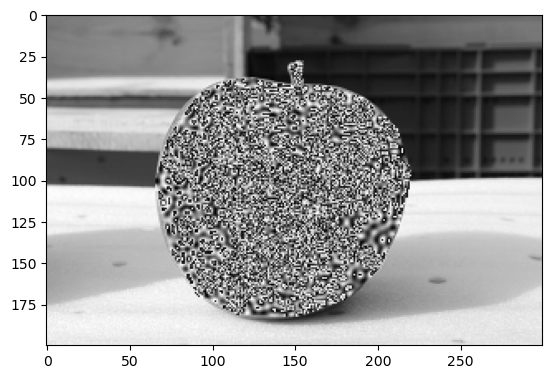

In [288]:
plt.imshow(target, cmap='gray')